# Try Li Plating Sub Models

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_model/"
res_DIR = "../data/results_model/"
%matplotlib widget

In [2]:
parameter_values = get_parameter_values()

In [3]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
    }
)
spm_li = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
    }
)

spm_li_r = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "reversible",
    }
)

spm_li_pr = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "partially reversible",
    }
)

spme = pybamm.lithium_ion.SPMe(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
    }
)
spme_li = pybamm.lithium_ion.SPMe(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
    }
)
# spm.print_parameter_info()
param=spm_li.param

In [4]:
cell = 4
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(Temp)

25


In [5]:
parameter_values.update(
    {
      "Negative electrode active material volume fraction": eps_n_data,
      "Positive electrode active material volume fraction": eps_p_data,
      "Positive electrode LAM constant proportional term [s-1]": 1.27152e-07,
      "Negative electrode LAM constant proportional term [s-1]": 1.27272e-06,
      "Positive electrode LAM constant exponential term": 1.1992,
      "Negative electrode LAM constant exponential term": 1.1992,
      "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
      "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
      "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
      "Lithium plating kinetic rate constant [m.s-1]": 1e-9,
      "Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]": 4.244E-6,
      "Li plating open-circuit potential [V]":0.0,
      # "Lithium plating transfer coefficient": 0.65,
      # "Exchange-current density for plating [A.m-2]":0.002,
      # "Lithium plating transfer coefficient": 0.7,
      # "Dead lithium decay constant [s-1]": 1E-4,
    },
    check_already_exists=False,
)

In [6]:
parameter_values.search('plating')

Exchange-current density for plating [A.m-2]	<function plating_exchange_current_density_Mohtat2020 at 0x000001FA004D73A0>
Li plating open-circuit potential [V]	0.0
Lithium plating kinetic rate constant [m.s-1]	1e-09
Lithium plating transfer coefficient	0.65


In [7]:
# c_rate_d = '2C'
# c_rate_c = '1.5C'
c_rate_c ='C/5'
SOC_0 = 0

In [8]:
# pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
# pybamm.set_logging_level("INFO")
# pybamm.set_logging_level("VERBOSE")
# pybamm.set_logging_level("SPAM")
experiment = pybamm.Experiment(
    [
        (
         "Rest for 10 minutes", 
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
        #  "Rest for 20 minutes",
         )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)

# experiment = pybamm.Experiment(
#     [
#         (
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50",
#          "Rest for 5 min",
#          "Discharge at "+c_rate_d+" until 3V",
#          )
#     ],
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
# SOC_0 = 0 

# experiment = pybamm.Experiment(
#     [
#         (
#         #  "Charge at "+c_rate_c+" until 4.2V", 
#         #  "Hold at 4.2V until C/50",
#         #  "Rest for 5 min",
#          "Discharge at "+c_rate_d+" until 3V",
#          )
#     ],
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
# SOC_0 = 1

In [9]:
sim_long = pybamm.Simulation(spm_li, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution1 = sol_long

sim_long1 = pybamm.Simulation(spm_li_r, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long1 = sim_long1.solve(initial_soc=SOC_0)
solution1_r = sol_long1

2022-12-14 15:30:43.946 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (31.043 ms elapsed) --------------------
2022-12-14 15:30:43.948 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/3: Rest for 10 minutes
2022-12-14 15:30:44.093 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/3: Charge at C/5 until 4.2V
2022-12-14 15:30:45.098 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 3/3: Hold at 4.2V until C/50
2022-12-14 15:30:45.862 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.782 Ah (originally 4.782 Ah, will stop at 2.391 Ah)
2022-12-14 15:30:45.864 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 1.947 s
2022-12-14 15:30:49.347 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (27.711 ms elapsed) --------------------
2022-12-14 15:30:49.348 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/3: Rest for 10 minutes
2022-12-14 15:30:49.462 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/3: C

In [10]:
# parameter_values.update(
#     {
#     #   "Exchange-current density for plating [A.m-2]":0.001,
#     #   "Lithium plating transfer coefficient": 0.5,
#     #   "Dead lithium decay constant [s-1]": 1E-4,
#         # "Exchange-current density for stripping [A.m-2]": 0.00005,
#     },
#     check_already_exists=False,
# )
c_rate_c ='1.5C'
experiment = pybamm.Experiment(
    [
        (
         "Rest for 10 minutes",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
        #  "Rest for 20 minutes",
         )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)
# experiment = pybamm.Experiment(
#     [
#         (
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50",
#          "Rest for 5 min",
#          "Discharge at "+c_rate_d+" until 3V",
#          )
#     ],
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
# SOC_0 = 0 

sim_long = pybamm.Simulation(spm_li, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution2 = sol_long

sim_long1 = pybamm.Simulation(spm_li_r, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long1 = sim_long1.solve(initial_soc=SOC_0)
solution2_r = sol_long1

2022-12-14 15:30:55.540 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (38.277 ms elapsed) --------------------
2022-12-14 15:30:55.542 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/3: Rest for 10 minutes
2022-12-14 15:30:55.698 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/3: Charge at 1.5C until 4.2V
2022-12-14 15:30:56.170 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 3/3: Hold at 4.2V until C/50
2022-12-14 15:30:57.185 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.823 Ah (originally 4.823 Ah, will stop at 2.412 Ah)
2022-12-14 15:30:57.187 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 1.683 s
2022-12-14 15:31:00.166 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (20.287 ms elapsed) --------------------
2022-12-14 15:31:00.168 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/3: Rest for 10 minutes
2022-12-14 15:31:00.266 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/3: 

In [11]:
# # x = [0.75623191, 1.02509399, 4.04314049, 4.58122543]
# x = [1,1,1,1]
# parameter_values.update(
#     {
#       # "Exchange-current density for plating [A.m-2]":0.002,
#       # "Lithium plating transfer coefficient": 0.7,
#       # "Dead lithium decay rate [s-1]": 1E-4,
#       # "Initial outer SEI thickness [m]": 100*5e-09,
#       "Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]": x[0]*1*4.244E-6,
#       "Positive electrode reference exchange-current density [A.m-2(m3.mol)1.5]":	x[1]*4.824e-06,
#       "Negative electrode diffusion coefficient [m2.s-1]": x[2]*8e-14,
#       "Positive electrode diffusion coefficient [m2.s-1]": x[3]*8e-15,
#     },
#     check_already_exists=False,
# )

# sim_long = pybamm.Simulation(spm_li_r, experiment=experiment, parameter_values=parameter_values, 
#                             solver=pybamm.CasadiSolver("safe"))
# sol_long = sim_long.solve(initial_soc=SOC_0)
# solution3 = sol_long

In [12]:
# spm_li.variables.search("exchange")

In [13]:
# fig, axes = plt.subplots(2, 3, figsize=(8, 6))
# ax1 = axes.flat[0]
# ax1.plot(t1,V1,'b')
# ax1.plot(t2,V2,'rv-')
# ax1.set_title('Voltage [V]')
# ax3 = axes.flat[3]
# ax3.plot(t1,phi_pl1,'b')
# ax3.plot(t2,phi_pl2,'rv-')
# ax3.set_ylim([-0.1,1])
# ax3.set_title('Plating Overpotential [V]')
# ax4 = axes.flat[5]
# ax4.plot(t1,phi_sei1,'b')
# ax4.plot(t2,phi_sei2,'rv-')
# # ax4.set_ylim([-0.1,1])
# ax4.set_title('SEI Overpotential [V]')
# ax2 = axes.flat[2]
# ax2.plot(t1,Q_Li1,'b')
# ax2.plot(t2,Q_Li2,'rv-')
# ax2.set_title('Capacity lost due to plating [Ah]')
# ax6=axes.flat[1]
# ax6.plot(t1,I_Li1,'b')
# ax6.plot(t2,I_Li2,'rv-')
# ax6.set_title('Lithium plating interfacial current density')
# ax5=axes.flat[4]
# ax5.plot(t1,phi_del1,'b')
# ax5.plot(t2,phi_del2,'rv-')
# ax5.set_ylim([-0.1,1])

# ax1.plot(t3,V3,'g--')
# ax3.plot(t3,phi_pl3,'g--')
# ax4.plot(t3,phi_sei3,'g--')
# ax2.plot(t3,Q_Li3,'g--')
# ax6.plot(t3,I_Li3,'g--')
# ax5.plot(t3,phi_del3,'g--')
# ax5.set_title('Neg Elec Surf Pot Diff [V]')
# # ax5.set_ylim([-0.1,1])
# # ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# # ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
# ax1.legend(['C/5','1.5C','New Params'])
# # ax1.legend(['SPM','SPMe'])
# fig.tight_layout()
# # plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
# plt.savefig(fig_DIR+'plating_compare_crate'+'.png')
# # plt.savefig(fig_DIR+'plating_compare_spme'+'.png')

In [14]:
# spm_li.variables.search("negative concentration")

In [15]:
def plot_vars(solution):
    t =  solution["Time [s]"].entries
    t = t/3600
    V =  solution["Terminal voltage [V]"].entries
    I =  solution["Current [A]"].entries
    Q = -solution['Discharge capacity [A.h]'].entries
    Q_Li = solution["Loss of capacity to lithium plating [A.h]"].entries
    I_Li = solution["X-averaged lithium plating interfacial current density [A.m-2]"].entries

    I_de = solution["X-averaged negative electrode interfacial current density [A.m-2]"].entries
    I_st = solution["X-averaged lithium plating interfacial current density"].entries
    I_to = solution["X-averaged negative electrode total interfacial current density [A.m-2]"].entries

    phi_seif = solution["X-averaged SEI film overpotential [V]"].entries
    phi_sei  = solution["X-averaged negative electrode sei reaction overpotential [V]"].entries
    # phi_sei = 0
    phi_pl  = solution["X-averaged negative electrode lithium plating reaction overpotential [V]"].entries
    phi_pl_nd  = solution["X-averaged negative electrode lithium plating reaction overpotential"].entries
    phi_del = solution["X-averaged negative electrode surface potential difference [V]"].entries

    phi_ocp = solution["X-averaged negative electrode open circuit potential [V]"].entries
    phi_int = solution["X-averaged negative electrode reaction overpotential [V]"].entries

    i0_int = solution["X-averaged negative electrode exchange current density [A.m-2]"].entries
    phi_e_avg = solution["X-averaged negative electrolyte potential [V]"].entries
    c_e_avg = solution["X-averaged negative electrolyte concentration [mol.m-3]"].entries
    c_ss_n = solution["X-averaged negative particle surface concentration [mol.m-3]"].entries
    c_save_n1 = solution["R-averaged negative particle concentration [mol.m-3]"].entries
    c_save_n = c_save_n1[1,:]
    c_s_n = solution["X-averaged negative particle concentration [mol.m-3]"].entries

    return t,V,I,Q,Q_Li,I_Li,I_de,I_st,I_to,phi_seif,phi_sei,phi_pl,phi_del,phi_ocp,phi_int,i0_int,phi_e_avg,c_e_avg,c_ss_n,c_save_n,c_s_n

In [16]:
# fig, axes = plt.subplots(3, 1, figsize=(6,8))
# ax1 = axes.flat[0]
# ax1.plot(Q1,phi_ocp1,'b')
# ax1.plot(Q2,phi_ocp2,'rv-')
# ax1.set_title('Negative Electrode Open Circuit Potential [V]')
# ax2 = axes.flat[1]
# ax2.plot(Q1,phi_int1,'b')
# ax2.plot(Q2,phi_int2,'rv-')
# ax2.set_title('Negative Electrode Intercalation Overpotential [V]')
# ax3 = axes.flat[2]
# ax3.plot(Q1,phi_pl1,'b')
# ax3.plot(Q2,phi_pl2,'rv-')
# ax3.set_title('Plating Overpotential [V]')
# # ax5.set_ylim([-0.1,1])
# # ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# # ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
# ax1.legend(['C/5','1.5C','High R'])
# # ax1.legend(['SPM','SPMe'])
# fig.tight_layout()
# # plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
# # plt.savefig(fig_DIR+'plating_compare_crate'+'.png')
# # plt.savefig(fig_DIR+'plating_compare_spme'+'.png')

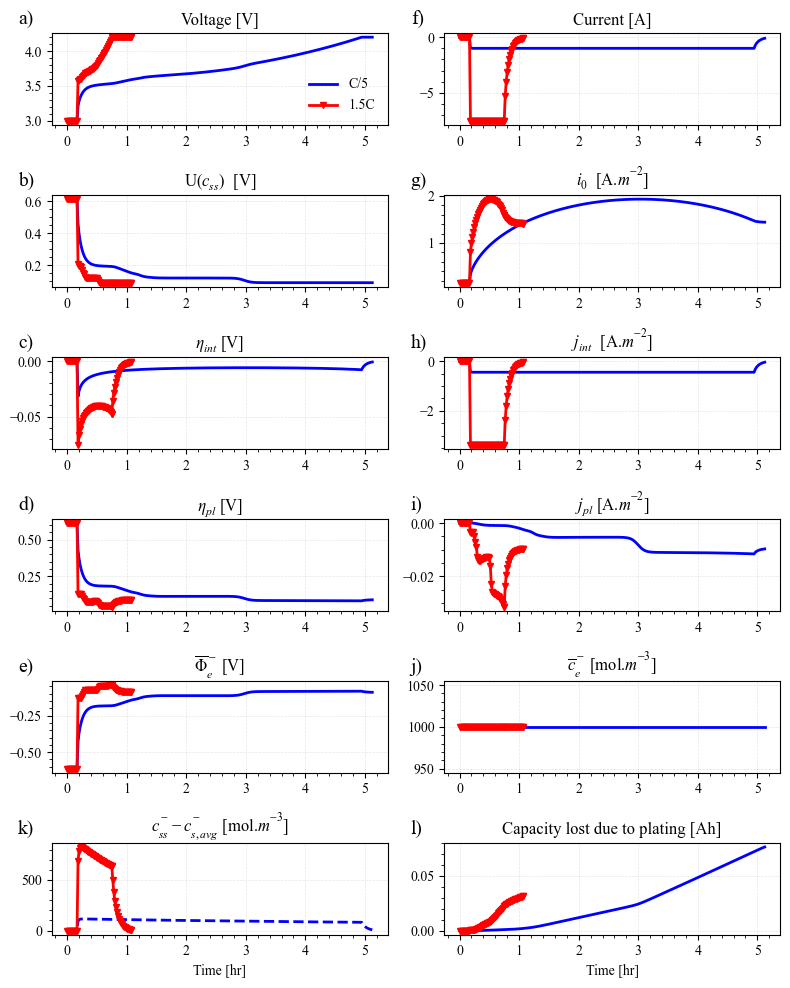

In [17]:
t1,V1,I1,Q1,Q_Li1,I_Li1,I_de1,I_st1,I_to1,phi_seif1,phi_sei1,phi_pl1,phi_del1,phi_ocp1,phi_int1,i0_int1,phi_e_avg1,c_e_avg1,c_ss_n1,c_save_n1,c_s_n1 = plot_vars(solution1)
t2,V2,I2,Q2,Q_Li2,I_Li2,I_de2,I_st2,I_to2,phi_seif2,phi_sei2,phi_pl2,phi_del2,phi_ocp2,phi_int2,i0_int2,phi_e_avg2,c_e_avg2,c_ss_n2,c_save_n2,c_s_n2 = plot_vars(solution2)
fig, axes = plt.subplots(6, 2, figsize=(8, 10))
ax1 = axes.flat[0]
ax1.plot(t1,V1,'b')
ax1.plot(t2,V2,'rv-')
ax1.set_title('Voltage [V]')
ax2 = axes.flat[2]
ax2.plot(t1,phi_ocp1,'b')
ax2.plot(t2,phi_ocp2,'rv-')
ax2.set_title(r'U($c_{ss})$  [V]')
ax3 = axes.flat[6]
ax3.plot(t1,phi_pl1,'b')
ax3.plot(t2,phi_pl2,'rv-')
ax3.set_title(r'$\eta_{pl}$ [V]')
ax4=axes.flat[3]
ax4.plot(t1,i0_int1,'b')
ax4.plot(t2,i0_int2,'rv-')
ax4.set_title(r'$i_0$  [A.$m^{-2}$]')
ax5=axes.flat[4]
ax5.plot(t1,phi_int1,'b')
ax5.plot(t2,phi_int2,'rv-')
ax5.set_title(r'$\eta_{int}$ [V]')
ax6=axes.flat[7]
ax6.plot(t1,I_Li1,'b')
ax6.plot(t2,I_Li2,'rv-')
ax6.set_title(r'$j_{pl}$ [A.$m^{-2}$]')
ax7 = axes.flat[1]
ax7.plot(t1,I1,'b')
ax7.plot(t2,I2,'rv-')
ax7.set_title('Current [A]')
ax8=axes.flat[5]
ax8.plot(t1,I_to1,'b')
ax8.plot(t2,I_to2,'rv-')
ax8.set_title(r'$j_{int}$  [A.$m^{-2}$]')
ax9=axes.flat[8]
ax9.plot(t1,phi_e_avg1,'b')
ax9.plot(t2,phi_e_avg2,'rv-')
ax9.set_title(r'$\overline{\Phi}^-_{e}$ [V]')
ax10=axes.flat[9]
ax10.plot(t1,c_e_avg1,'b')
ax10.plot(t2,c_e_avg2,'rv-')
ax10.set_title(r'$\overline{c}^-_{e}$ [mol.$m^{-3}$]')

ax11 = axes.flat[10]
ax11.plot(t1,c_ss_n1-c_save_n1,'b--')
# ax11.plot(t1,c_save_n1,'b--')
ax11.plot(t2,c_ss_n2-c_save_n2,'rv-')
# ax11.plot(t2,c_save_n2,'r--')
# ax11.legend(['surf','ave'])
ax11.set_title(r'$c_{ss}^--c_{s,avg}^-$ [mol.$m^{-3}$]')
ax12 = axes.flat[11]
ax12.plot(t1,Q_Li1,'b')
ax12.plot(t2,Q_Li2,'rv-')
ax12.set_title('Capacity lost due to plating [Ah]')

ax11.set_xlabel("Time [hr]")
ax12.set_xlabel("Time [hr]")
# ax5.set_ylim([-0.1,1])
# ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
ax1.legend(['C/5','1.5C'])
axis = [ax1,ax2,ax5,ax3,ax9,ax7,ax4,ax8,ax6,ax10,ax11,ax12]
labels = ["a)","b)","c)","d)","e)","f)","g)","h)","i)","j)","k)","l)"]
for ax, label in zip(axis,labels):
  ax.text(-0.1,1.1,label,transform=ax.transAxes, fontsize=14)  

# ax1.legend(['SPM','SPMe'])
fig.tight_layout()
# plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
# plt.savefig(fig_DIR+'plating_compare_models_1p5C'+'.png')
plt.savefig(fig_DIR+'plating_compare_crate_full'+'.png')

In [18]:
i_pl_area1 = np.trapz(I_Li1,t1)
i_pl_avg1 = i_pl_area1/t1[-1]
i_pl_area2 = np.trapz(I_Li2,t2)
i_pl_avg2 = i_pl_area2/t2[-1]
print(i_pl_avg1)
print(i_pl_avg2)
print(i_pl_avg2/i_pl_avg1)
print(Q_Li2[-1]/Q_Li1[-1])

-0.006667710336279368
-0.013186339203358608
1.9776412798874947
0.4130142259939504


In [19]:
sadas

NameError: name 'sadas' is not defined

In [ ]:
t1,V1,I1,Q1,Q_Li1,I_Li1,I_de1,I_st1,I_to1,phi_seif1,phi_sei1,phi_pl1,phi_del1,phi_ocp1,phi_int1,i0_int1,phi_e_avg1,c_e_avg1,c_ss_n1,c_save_n1,c_s_n1 = plot_vars(solution1)
t2,V2,I2,Q2,Q_Li2,I_Li2,I_de2,I_st2,I_to2,phi_seif2,phi_sei2,phi_pl2,phi_del2,phi_ocp2,phi_int2,i0_int2,phi_e_avg2,c_e_avg2,c_ss_n2,c_save_n2,c_s_n2 = plot_vars(solution2)
fig, axes = plt.subplots(6, 2, figsize=(8, 10))
ax1 = axes.flat[0]
ax1.plot(t1,V1,'b')
ax1.plot(t2,V2,'rv-')
ax1.set_title('Voltage [V]')
ax2 = axes.flat[2]
ax2.plot(t1,phi_ocp1,'b')
ax2.plot(t2,phi_ocp2,'rv-')
ax2.set_title(r'U($c_{ss})$  [V]')
ax3 = axes.flat[6]
ax3.plot(t1,phi_pl1,'b')
ax3.plot(t2,phi_pl2,'rv-')
ax3.set_title(r'$\eta_{pl}$ [V]')
ax4=axes.flat[3]
ax4.plot(t1,i0_int1,'b')
ax4.plot(t2,i0_int2,'rv-')
ax4.set_title(r'$i_0$  [A.$m^{-2}$]')
ax5=axes.flat[4]
ax5.plot(t1,phi_int1,'b')
ax5.plot(t2,phi_int2,'rv-')
ax5.set_title(r'$\eta_{int}$ [V]')
ax6=axes.flat[7]
ax6.plot(t1,I_Li1,'b')
ax6.plot(t2,I_Li2,'rv-')
ax6.set_title(r'$j_{pl}$ [A.$m^{-2}$]')
ax7 = axes.flat[1]
ax7.plot(t1,I1,'b')
ax7.plot(t2,I2,'rv-')
ax7.set_title('Current [A]')
ax8=axes.flat[5]
ax8.plot(t1,I_to1,'b')
ax8.plot(t2,I_to2,'rv-')
ax8.set_title(r'$j_{int}$  [A.$m^{-2}$]')
ax9=axes.flat[8]
ax9.plot(t1,phi_e_avg1,'b')
ax9.plot(t2,phi_e_avg2,'rv-')
ax9.set_title(r'$\overline{\Phi}^-_{e}$ [V]')
ax10=axes.flat[9]
ax10.plot(t1,c_e_avg1,'b')
ax10.plot(t2,c_e_avg2,'rv-')
ax10.set_title(r'$\overline{c}^-_{e}$ [mol.$m^{-3}$]')

ax11 = axes.flat[10]
ax11.plot(t1,c_ss_n1-c_save_n1,'b--')
# ax11.plot(t1,c_save_n1,'b--')
ax11.plot(t2,c_ss_n2-c_save_n2,'r')
# ax11.plot(t2,c_save_n2,'r--')
ax11.legend(['surf','ave'])
ax11.set_title(r'$c_s^-$ [mol.$m^{-3}$]')
ax12 = axes.flat[11]
ax12.plot(t1,Q_Li1,'b')
ax12.plot(t2,Q_Li2,'rv-')
ax12.set_title('Capacity lost due to plating [Ah]')

ax11.set_xlabel("Time [hr]")
ax12.set_xlabel("Time [hr]")
# ax5.set_ylim([-0.1,1])
# ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
ax1.legend(['1.5C','2C'])
axis = [ax1,ax2,ax5,ax3,ax9,ax7,ax4,ax8,ax6,ax10,ax11,ax12]
labels = ["a)","b)","c)","d)","e)","f)","g)","h)","i)","j)","k)","l)"]
for ax, label in zip(axis,labels):
  ax.text(-0.1,1.1,label,transform=ax.transAxes, fontsize=14)  

# ax1.legend(['SPM','SPMe'])
fig.tight_layout()
# plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
# plt.savefig(fig_DIR+'plating_compare_models_1p5C'+'.png')
plt.savefig(fig_DIR+'plating_compare_crate_high_irrev'+'.png')

In [ ]:
asdasd

In [ ]:
c_smax_n = 28746
f1 = (c_ss_n1**0.5)*((c_smax_n-c_ss_n1)**0.5)

In [ ]:

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
ax1.plot(t1,f1,'b')
# ax1.plot(t2,V2,'rv-')
ax1.set_title(r'$(c_{s,max}-c_{ss})^{1-\alpha}\times(c_{ss})^{\alpha}$')
ax1.set_xlabel("Time [hr]")
plt.savefig(fig_DIR+'exch_current_nonlinearity'+'.png')

In [ ]:
# t1,V1,I1,Q1,Q_Li1,I_Li1,I_de1,I_st1,I_to1,phi_seif1,phi_sei1,phi_pl1,phi_del1,phi_ocp1,phi_int1,i0_int1,phi_e_avg1,c_e_avg1,c_ss_n1,c_save_n1,c_s_n1 = plot_vars(solution1_r)
# t2,V2,I2,Q2,Q_Li2,I_Li2,I_de2,I_st2,I_to2,phi_seif2,phi_sei2,phi_pl2,phi_del2,phi_ocp2,phi_int2,i0_int2,phi_e_avg2,c_e_avg2,c_ss_n2,c_save_n2,c_s_n2 = plot_vars(solution2_r)
r = np.linspace(0,1,20)
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(r,c_s_n1[:,11]-c_s_n1[0,11],'b')
ax1.plot(r,c_s_n2[:,11]-c_s_n2[0,11],'rv-')
ax1.set_title('Negative Concentration 1 min after charge')
ax1.legend(['C/5','1.5 C'])
fig.tight_layout()
# plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
# plt.savefig(fig_DIR+'plating_compare_crate'+'.png')
# plt.savefig(fig_DIR+'plating_compare_spme'+'.png')